<a href="https://colab.research.google.com/github/PRASANNA-416/IT414-Mini-Project/blob/main/MultiResUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import os
import tensorflow as tf
from tqdm import tqdm
import cv2

input_dir = "/content/gdrive/MyDrive/ML/kvasir-seg/Kvasir-SEG/images"
target_dir = "/content/gdrive/MyDrive/ML/kvasir-seg/Kvasir-SEG/masks"

num_input_images = len(os.listdir(input_dir))
num_target_images = len(os.listdir(target_dir))

print("Number of input images:", num_input_images)
print("Number of target images:", num_target_images)

Number of input images: 1000
Number of target images: 1000


In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import Sequence
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(Sequence):
    def __init__(self, input_dir, mask_dir, batch_size, target_size=(224, 224), shuffle=True):
        self.input_dir = input_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle

        # Get list of image and mask file names
        self.filenames = os.listdir(self.input_dir)

        # Get number of batches per epoch
        self.steps_per_epoch = len(self.filenames) // self.batch_size

        # Shuffle filenames
        if self.shuffle:
            np.random.shuffle(self.filenames)

        # Set up data augmentation generator
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, index):
        # Get batch indexes
        batch_filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Initialize batch arrays
        batch_input = np.zeros((self.batch_size, *self.target_size, 3))
        batch_mask = np.zeros((self.batch_size, *self.target_size, 1))

        # Load and augment batch images and masks
        for i, filename in enumerate(batch_filenames):
            # Load input image
            input_path = os.path.join(self.input_dir, filename)
            input_img = load_img(input_path, target_size=self.target_size)
            input_array = img_to_array(input_img)

            # Load target mask
            mask_path = os.path.join(self.mask_dir, filename)
            mask_img = load_img(mask_path, target_size=self.target_size, color_mode='grayscale')
            mask_array = img_to_array(mask_img)

            # Apply data augmentation to input and mask images
            input_array, mask_array = self.apply_data_augmentation(input_array, mask_array)

            # Normalize input image and mask
            input_array = input_array / 255.0
            mask_array = mask_array / 255.0

            # Add to batch arrays
            batch_input[i] = input_array
            batch_mask[i] = mask_array

        return batch_input, batch_mask

    def apply_data_augmentation(self, input_array, mask_array):
        # Combine input and mask arrays for data augmentation
        combined = np.concatenate([input_array, mask_array], axis=2)

        # Apply data augmentation
        augmented = self.datagen.random_transform(combined)

        # Split augmented array back into input and mask arrays
        aug_input = augmented[..., :3]
        aug_mask = augmented[..., 3:]

        return aug_input, aug_mask


In [4]:
image_dir = '/content/gdrive/MyDrive/ML/kvasir-seg/Kvasir-SEG/images'
mask_dir = '/content/gdrive/MyDrive/ML/kvasir-seg/Kvasir-SEG/masks'

# Define the batch size and target image size
batch_size = 10
target_size = (224, 224)

# Create the custom data generator
data_generator = CustomDataGenerator(image_dir, mask_dir, batch_size, target_size)

In [5]:
num_images = 0
num_masks = 0
for batch in data_generator:
    num_images += batch[0].shape[0]
    num_masks += batch[1].shape[0]
print("Total number of images:", num_images)
print("Total number of masks:", num_masks)

Total number of images: 1000
Total number of masks: 1000


In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model




In [8]:

from keras.metrics import MeanIoU

def dice_coefficient(y_true, y_pred, smooth=1.0):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true), axis=-1) + K.sum(K.square(y_pred), axis=-1) + smooth)


In [9]:
def trainStep(model, X_train, Y_train,epochs, batchSize):

    
    for epoch in range(epochs):
        print('Epoch : {}'.format(epoch+1))
        model.fit(x=X_train, y=Y_train, batch_size=batchSize, epochs=1, verbose=1)     


    return model 

In [10]:
model = MultiResUnet(height=224, width=224, n_channels=3)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 8)  216         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 224, 224, 8)  24         ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                              

In [16]:
from tensorflow.keras.metrics import MeanIoU
mean_iou = MeanIoU(num_classes=1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coefficient])



In [17]:
model.fit(data_generator, epochs=10,steps_per_epoch = 10)

Epoch 1/10
10/10 [==============================] - 267s 22s/step - loss: 0.6746 - accuracy: 0.6611 - dice_coefficient: 0.8408
Epoch 2/10
10/10 [==============================] - 222s 22s/step - loss: 0.6748 - accuracy: 0.6450 - dice_coefficient: 0.8382
Epoch 3/10
10/10 [==============================] - 220s 22s/step - loss: 0.6528 - accuracy: 0.6623 - dice_coefficient: 0.8443
Epoch 4/10
10/10 [==============================] - 212s 21s/step - loss: 0.6200 - accuracy: 0.7037 - dice_coefficient: 0.8485
Epoch 5/10
10/10 [==============================] - 215s 22s/step - loss: 0.6216 - accuracy: 0.7532 - dice_coefficient: 0.8498
Epoch 6/10
10/10 [==============================] - 216s 22s/step - loss: 0.5994 - accuracy: 0.7797 - dice_coefficient: 0.8571
Epoch 7/10
10/10 [==============================] - 220s 22s/step - loss: 0.6075 - accuracy: 0.7444 - dice_coefficient: 0.8558
Epoch 8/10
10/10 [==============================] - 225s 23s/step - loss: 0.6071 - accuracy: 0.7322 - dice_coef

In [18]:
model.save_weights('multiResUNET.h5')


In [19]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Define the testing directory containing images and masks
testing_dir = '/content/gdrive/MyDrive/ML/kvasir-sessile/sessile-main-Kvasir-SEG'
images_dir = '/content/gdrive/MyDrive/ML/kvasir-sessile/sessile-main-Kvasir-SEG/images'
masks_dir = '/content/gdrive/MyDrive/ML/kvasir-sessile/sessile-main-Kvasir-SEG/masks'

# Define the target image size
target_size = (224, 224)

# Get the list of image file names
image_files = os.listdir(images_dir)

# Sort the list of file names
image_files.sort()

# Create empty lists for images and masks
input_images = []
actual_masks = []

# Loop over the image file names
for i in range(len(image_files)):
    # Load the input image
    image_path = os.path.join(images_dir, image_files[i])
    input_image = load_img(image_path, target_size=target_size)
    input_image_array = img_to_array(input_image) / 255.0
    input_images.append(input_image_array)

    # Load the actual mask
    mask_file = image_files[i].split('.')[0] + '.jpg'
    mask_path = os.path.join(masks_dir, mask_file)
    actual_mask = load_img(mask_path, color_mode='grayscale', target_size=target_size)
    actual_mask_array = img_to_array(actual_mask) / 255.0
    actual_masks.append(actual_mask_array)

# Convert the lists of images and masks to arrays
input_images = np.array(input_images)
actual_masks = np.array(actual_masks)


# Convert lists to numpy arrays
x = np.array(input_images)
y = np.array(actual_masks)

# Normalize input images
x = x / 255.0

# Change label 2 to 1
y[y == 2] = 1

print("Input images shape:", x.shape)
print("Target images shape:", y.shape)

Input images shape: (196, 224, 224, 3)
Target images shape: (196, 224, 224, 1)


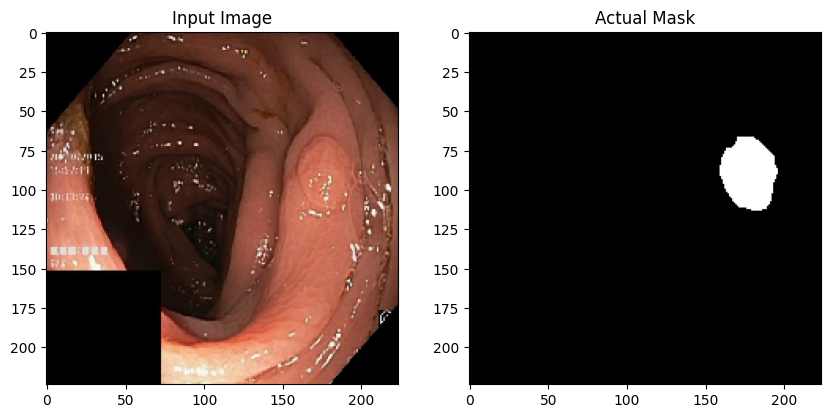

In [20]:
import matplotlib.pyplot as plt

# Plot the first image and its mask
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(input_images[4])
axes[0].set_title('Input Image')

axes[1].imshow(actual_masks[4], cmap='gray')
axes[1].set_title('Actual Mask')

plt.show()


In [24]:

loss, accuracy, dice = model.evaluate(x, y, verbose=0)

print(f'Testing loss: {loss:.4f}, Testing accuracy: {accuracy:.4f}, Testing dice: {dice:.4f}')

Testing loss: 24.8769, Testing accuracy: 0.2209, Testing dice: 0.6049
